In [187]:
import os
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-20"
# If you are using environments in Python, you can set the environment variables like this:
os.environ["PYSPARK_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
#os.environ["PYSPARK_DRIVER_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
# Set the Hadoop version to the one you are using, e.g., none:
#os.environ["PYSPARK_HADOOP_VERSION"] = "without"

In [188]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()
# Some warnings are to be expected.

In [189]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

<h1> Pivioting

In [190]:
# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

In [191]:
# Creating a keyspace
session.execute("CREATE KEYSPACE IF NOT EXISTS fish_keyspace WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };")

In [192]:
# set keyspace
session.set_keyspace('fish_keyspace')

In [193]:
df_fish = spark.read.format("org.apache.spark.sql.cassandra").options(table="fish_table_year", keyspace="fish_keyspace").load()
df_fish.show()

+--------------+------------------+----------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+----------+---------+------------+--------------+-------------------+----+----+
|localityweekid|avgadultfemalelice|      date|hascleanerfishdeployed|hasila|hasmechanicalremoval|haspd|hasreportedlice|hassalmonoids|hassubstancetreatments|infilteredselection|isfallow|isonland|isslaughterholdingcage|      lat|localityno|      lon|municipality|municipalityno|               name|week|year|
+--------------+------------------+----------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+----------+---------+------------+--------------+-------------------+----+----+
|       1653764|              null|2023-10-30|                 false| false|   

In [194]:
# Make spark dataframe to pandas dataframe
df_fish = df_fish.toPandas()

In [195]:
# Create a variable called region, splitting Norway into three regions: South - below 63.81 latitude, Middle - up to 68.85 latitude, North - above 68.85 latitude.
df_fish['region'] = 'NaN'
df_fish.loc[df_fish['lat'] < 63.81, 'region'] = 'South'
df_fish.loc[(df_fish['lat'] >= 63.81) & (df_fish['lat'] <= 68.85), 'region'] = 'Middle'
df_fish.loc[df_fish['lat'] > 68.85, 'region'] = 'North'

In [196]:
# combine year and week into new column called year_week
df_fish['year_week'] = df_fish['year'].astype(str) + '-' + df_fish['week'].astype(str)

In [197]:
# Create the following "Gropuby"s: category: week and values: avgadultfemalelice
df_fish_grouped = df_fish.groupby('year_week')['avgadultfemalelice'].mean().reset_index(name='avg_adult_female_lice')


In [198]:
df_fish_grouped.head()

,year_week,avg_adult_female_lice
0,2022-45,0.188433
1,2022-46,0.188252
2,2022-47,0.192589
3,2022-48,0.160068
4,2022-49,0.164200


In [199]:
import pandas as pd
# get the first date in each week and add it to the dataframe
df_fish_grouped['date'] = pd.to_datetime(df_fish_grouped['year_week'] + '-1', format="%Y-%W-%w")

# have to groupby year_week since the data spans over two years

In [200]:
df_fish_grouped.head()

,year_week,avg_adult_female_lice,date
0,2022-45,0.188433,2022-11-07
1,2022-46,0.188252,2022-11-14
2,2022-47,0.192589,2022-11-21
3,2022-48,0.160068,2022-11-28
4,2022-49,0.164200,2022-12-05


<Axes: xlabel='date'>

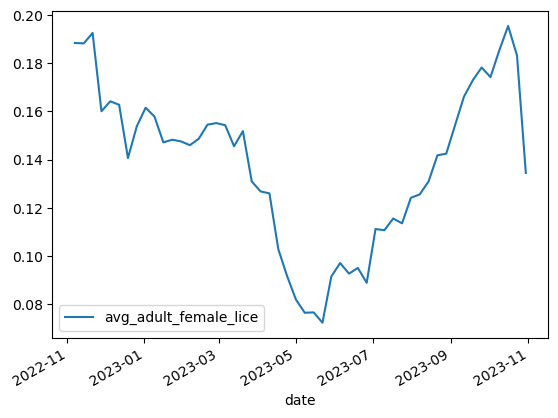

In [201]:
# plot the df_fish_grouped dataframe
import matplotlib.pyplot as plt

df_fish_grouped.plot(x='date', y='avg_adult_female_lice')


In [202]:
# Create the following piviot tables:
# category: haspd and haslla, values: lat

df_fish_pivot = df_fish.pivot_table(index='year_week', values=['haspd', 'hasila'], aggfunc='mean').reset_index()

In [203]:
df_fish_pivot.head()

,year_week,hasila,haspd
0,2022-45,0.006418,0.052509
1,2022-46,0.007585,0.052509
2,2022-47,0.007589,0.053123
3,2022-48,0.008168,0.053092
4,2022-49,0.008149,0.055879


In [204]:
# get the first date in each week and add it to the dataframe
df_fish_pivot['date'] = pd.to_datetime(df_fish_pivot['year_week'] + '-1', format="%Y-%W-%w")

In [205]:
df_fish_pivot.head()

,year_week,hasila,haspd,date
0,2022-45,0.006418,0.052509,2022-11-07
1,2022-46,0.007585,0.052509,2022-11-14
2,2022-47,0.007589,0.053123,2022-11-21
3,2022-48,0.008168,0.053092,2022-11-28
4,2022-49,0.008149,0.055879,2022-12-05


<Axes: xlabel='date'>

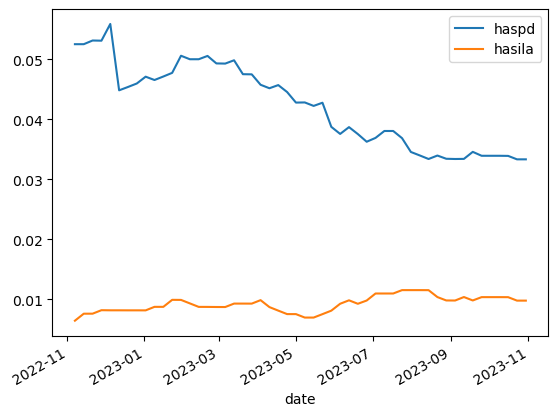

In [206]:
# plot the df_fish_pivot dataframe
df_fish_pivot.plot(x='date', y=['haspd', 'hasila'])

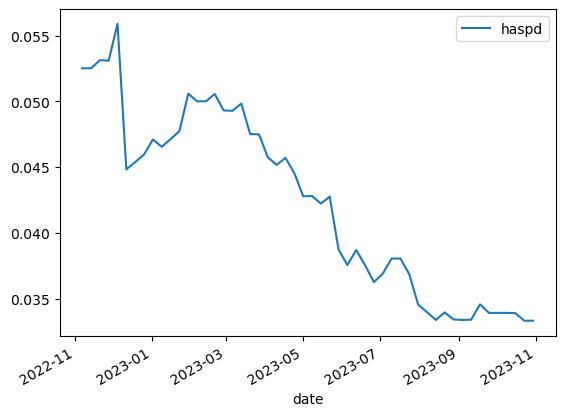

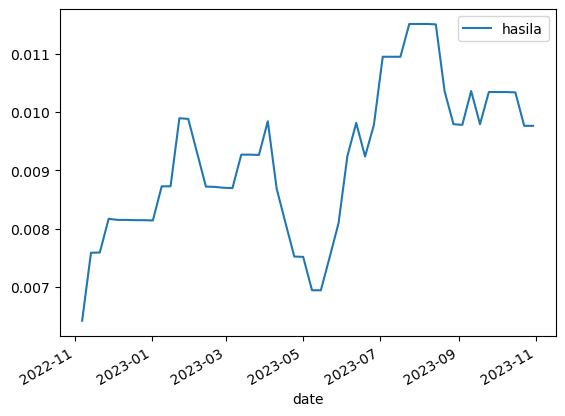

In [207]:
# Plot indepentently
df_fish_pivot.plot(x='date', y='haspd')
df_fish_pivot.plot(x='date', y='hasila')

plt.show()

In [208]:
# Create the following piviot tables:

# Category: region and year_week, values: avgadultfemalelice

df_fish_pivot2 = df_fish.pivot_table(index=['region', 'year_week'], values='avgadultfemalelice', aggfunc='mean').reset_index()

# Get the first date in each week and add it to the dataframe
df_fish_pivot2['date'] = pd.to_datetime(df_fish_pivot2['year_week'] + '-1', format="%Y-%W-%w")

<Axes: xlabel='date', ylabel='avgadultfemalelice'>

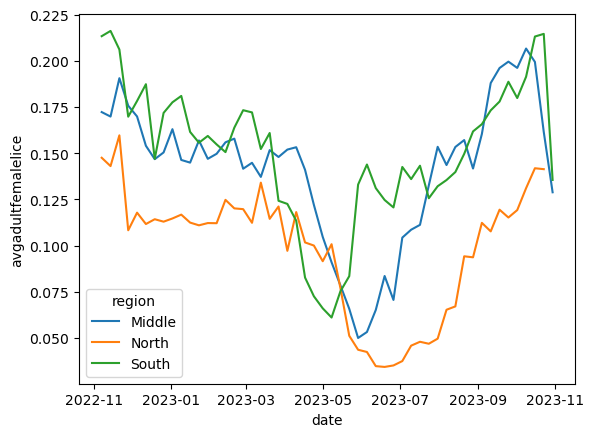

In [209]:
# Plot the df_fish_pivot2 dataframe with region as hue
import seaborn as sns
sns.lineplot(data=df_fish_pivot2, x='date', y='avgadultfemalelice', hue='region')

# you can see that the middle and north regions follows the south region with a delay of 1-2 months.

<h1> Forecasting

In [210]:
# Read from Cassandra - lice_count_table
df_lice = spark.read.format("org.apache.spark.sql.cassandra").options(table="lice_count_table", keyspace="fish_keyspace").load()

# make spark dataframe to pandas dataframe
df_lice = df_lice.toPandas()
df_lice.head()

,year_week,avgadultfemalelice,avgmobilelice,avgstationarylice,localityname,seatemperature,specieslist,week,year
0,2023-01-30,0.06,0.24,0.02,Andholmen 1,6.7,"['Laks', 'Ørret', 'Regnbueørret']",5,2023
1,2023-06-05,0.05,0.98,0.20,Andholmen 1,8.8,"['Laks', 'Ørret', 'Regnbueørret']",23,2023
2,2023-06-19,0.09,0.60,0.06,Andholmen 1,11.2,"['Laks', 'Ørret', 'Regnbueørret']",25,2023
3,2022-11-21,0.01,0.15,0.00,Andholmen 1,8.6,"['Laks', 'Ørret', 'Regnbueørret']",47,2022
4,2023-01-16,0.08,0.54,0.08,Andholmen 1,6.2,"['Laks', 'Ørret', 'Regnbueørret']",3,2023


In [211]:
# Drop the following columns: localityname, specieslist, week and year in df_lice
df_lice = df_lice.drop(['localityname', 'specieslist', 'week', 'year'], axis=1)
df_lice.head()

,year_week,avgadultfemalelice,avgmobilelice,avgstationarylice,seatemperature
0,2023-01-30,0.06,0.24,0.02,6.7
1,2023-06-05,0.05,0.98,0.20,8.8
2,2023-06-19,0.09,0.60,0.06,11.2
3,2022-11-21,0.01,0.15,0.00,8.6
4,2023-01-16,0.08,0.54,0.08,6.2


In [212]:
# Define the lagged correlation function
def lagged_correlation(lag=0, seatemperature='seatemperature', licetype='avgadultfemalelice'):
    y = df_lice[seatemperature]
    x = df_lice[licetype]

    # Apply the lag
    x_lagged = x.shift(lag)  # Shift the lice data by 'lag'
    valid_index = ~np.isnan(x_lagged) & ~np.isnan(y)  # Remove NaN values for correlation calculation
    corr = np.corrcoef(y[valid_index], x_lagged[valid_index])[0, 1]
    
    # Print the result
    print(f"Correlation between {seatemperature} and {licetype} lagged {lag} timepoints: {corr:.3f}")

# Define the function to calculate and plot the sliding window correlation
def plot_swc(center, window, seatemperature='seatemperature', licetype='avgadultfemalelice'):
    y = df_lice[seatemperature]
    x = df_lice[licetype]

    # Calculate the sliding window correlation
    swc = y.rolling(window, center=True).corr(x)

    # Define the window bounds
    window_start = max(center - window // 2, 0)
    window_end = min(center + window // 2, len(df_lice))
        
    # Plot the data
    plt.figure(figsize=(14, 7))

    # Plot sea temperature
    plt.subplot(3, 1, 1)
    plt.plot(y.index, y, label=seatemperature)
    plt.plot(y.index[window_start:window_end], y[window_start:window_end], 'r', label='Window Frame')
    plt.ylabel(seatemperature)
    plt.xlim(y.index.min(), y.index.max())

    # Plot lice type
    plt.subplot(3, 1, 2)
    plt.plot(x.index, x, label=licetype)
    plt.plot(x.index[window_start:window_end], x[window_start:window_end], 'r', label='Window Frame')
    plt.ylabel(licetype)
    plt.xlim(x.index.min(), x.index.max())

    # Plot the sliding window correlation
    plt.subplot(3, 1, 3)
    plt.plot(swc.index, swc, label='SWC')
    plt.axvline(x=swc.index[center], color='red', linestyle='--', label='Center')
    plt.ylabel('SWC')
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.ylim(-1, 1)
    plt.xlim(swc.index.min(), swc.index.max())
    plt.legend()
    plt.tight_layout()
    plt.show()

In [213]:
# Use interact to create the sliders and input options
interact(plot_swc,
         center=(1, len(df_lice)-1, 1),  # Center slider
         window=(1, len(df_lice)-1, 1),  # Window size slider
         seatemperature=['seatemperature'],  # Dropdown for sea temperature
         licetype=['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice'])  # Dropdown for lice types

# Also update the interact function for lagged_correlation
interact(lagged_correlation, lag=(0, len(df_lice)-1, 1),
         seatemperature=['seatemperature'],
         licetype=['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice'])

interactive(children=(IntSlider(value=26, description='center', max=51, min=1), IntSlider(value=26, descriptio…

interactive(children=(IntSlider(value=0, description='lag', max=51), Dropdown(description='seatemperature', op…

<function __main__.lagged_correlation(lag=0, seatemperature='seatemperature', licetype='avgadultfemalelice')>

<h3> Forecating part 2


In [214]:
# get combine_df from Cassandra
df_sync = spark.read.format("org.apache.spark.sql.cassandra").options(table="combine_table", keyspace="fish_keyspace").load()

# make spark dataframe to pandas dataframe
df_sync = df_sync.toPandas()
df_sync.head()


,referencetime,avgadultfemalelice,avgmobilelice,avgstationarylice,localityname,mean_air_temperature,mean_relative_humidity,mean_wind_speed,seatemperature,sum_precipitation_amount
0,2023-03-12,0.03,0.13,0.00,Andholmen 1,-1.485714,78.285714,7.085714,5.5,54.1
1,2023-09-17,0.28,0.74,0.06,Andholmen 1,11.928571,75.142857,6.757143,14.2,12.2
2,2022-12-04,0.03,0.26,0.03,Andholmen 1,5.542857,84.142857,3.728571,8.4,3.6
3,2023-10-29,0.16,0.34,0.01,Andholmen 1,6.050000,75.285714,4.271429,10.0,2.4
4,2023-03-26,0.02,0.11,0.00,Andholmen 1,2.192857,75.714286,5.842857,4.7,24.0


In [215]:
# drop the following columns: localityname
df_sync = df_sync.drop(['localityname'], axis=1)

In [216]:
df_sync['referencetime'] = pd.to_datetime(df_sync['referencetime'])

df_sync.index = df_sync['referencetime']

df_sync = df_sync.asfreq('W')

# drop the following columns: referencetime
df_sync = df_sync.drop(['referencetime'], axis=1)

#Sort the values in df_sync by referencetime
df_sync = df_sync.sort_values(by='referencetime')

In [217]:
# Make a bfill lag of one time step for each column except for referencetime

df_sync['avgadultfemalelice_lag'] = df_sync['avgadultfemalelice'].shift(1).bfill()
df_sync['avgmobilelice_lag'] = df_sync['avgmobilelice'].shift(1).bfill()
df_sync['avgstationarylice_lag'] = df_sync['avgstationarylice'].shift(1).bfill()
df_sync['seatemperature_lag'] = df_sync['seatemperature'].shift(1).bfill()
df_sync['mean_air_temperature_lag'] = df_sync['mean_air_temperature'].shift(1).bfill()
df_sync['mean_wind_speed_lag'] = df_sync['mean_wind_speed'].shift(1).bfill()
df_sync['mean_relative_humidity_lag'] = df_sync['mean_relative_humidity'].shift(1).bfill()
df_sync['sum_precipitation_amount_lag'] = df_sync['sum_precipitation_amount'].shift(1).bfill()


df_sync.head()

,avgadultfemalelice,avgmobilelice,avgstationarylice,mean_air_temperature,mean_relative_humidity,mean_wind_speed,seatemperature,sum_precipitation_amount,avgadultfemalelice_lag,avgmobilelice_lag,avgstationarylice_lag,seatemperature_lag,mean_air_temperature_lag,mean_wind_speed_lag,mean_relative_humidity_lag,sum_precipitation_amount_lag
referencetime,,,,,,,,,,,,,,,,
2022-11-13,0.02,0.05,0.02,9.164286,89.285714,7.000000,10.6,44.2,0.02,0.05,0.02,10.6,9.164286,7.000000,89.285714,44.2
2022-11-20,0.00,0.17,0.06,7.950000,64.142857,6.000000,10.3,0.1,0.02,0.05,0.02,10.6,9.164286,7.000000,89.285714,44.2
2022-11-27,0.01,0.15,0.00,5.450000,62.714286,6.685714,8.6,0.0,0.00,0.17,0.06,10.3,7.950000,6.000000,64.142857,0.1
2022-12-04,0.03,0.26,0.03,5.542857,84.142857,3.728571,8.4,3.6,0.01,0.15,0.00,8.6,5.450000,6.685714,62.714286,0.0
2022-12-11,0.06,0.28,0.03,1.071429,75.142857,8.785714,7.6,30.7,0.03,0.26,0.03,8.4,5.542857,3.728571,84.142857,3.6


In [218]:
import statsmodels.api as sm

# SARIMAX model 
mod = sm.tsa.statespace.SARIMAX(df_sync['seatemperature'], df_sync[["avgadultfemalelice", "avgmobilelice", "avgstationarylice", "mean_air_temperature", "mean_relative_humidity", "mean_wind_speed", "sum_precipitation_amount"]],\
    order=(1, 1, 1), seasonal_order=(0, 0, 0, 52), trend='c')
res = mod.fit(disp=False)
print(res.summary())

c:\Users\dinus\anaconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dinus\anaconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:         seatemperature   No. Observations:                   51
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -40.848
Date:                Thu, 09 Nov 2023   AIC                            103.696
Time:                        13:25:49   BIC                            124.729
Sample:                    11-13-2022   HQIC                           111.706
                         - 10-29-2023                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                   -0.0152      0.038     -0.404      0.686      -0.089       0.059
avgadultfemalelice          -0.9541      2.074     -0.460      0.646      -5.019       3.

c:\Users\dinus\anaconda3\envs\IND320\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [219]:
# SARIMAX model again with lagged variables

mod = sm.tsa.statespace.SARIMAX(df_sync['seatemperature'],\
    df_sync[["avgadultfemalelice", "avgmobilelice", "avgstationarylice", "mean_air_temperature", "mean_relative_humidity", "mean_wind_speed", "sum_precipitation_amount", "avgmobilelice_lag", "avgadultfemalelice_lag", "avgstationarylice_lag","mean_air_temperature_lag","mean_wind_speed_lag","mean_relative_humidity_lag", "sum_precipitation_amount_lag"]],\
    order=(1, 1, 1), seasonal_order=(0, 0, 0, 52), trend='c')
res = mod.fit(disp=False)
print(res.summary())

c:\Users\dinus\anaconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dinus\anaconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:         seatemperature   No. Observations:                   51
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -27.844
Date:                Thu, 09 Nov 2023   AIC                             91.687
Time:                        13:25:51   BIC                            126.104
Sample:                    11-13-2022   HQIC                           104.793
                         - 10-29-2023                                         
Covariance Type:                  opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
intercept                        0.0195      0.148      0.131      0.896      -0.271       0.310
avgadultfemalelice               0.7280      2.187      0.333      0.739     

c:\Users\dinus\anaconda3\envs\IND320\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [220]:
# removed everything above 0.4 in P>|z| and rerun the model
mod = sm.tsa.statespace.SARIMAX(df_sync['seatemperature'],\
    df_sync[[ "avgmobilelice", "mean_air_temperature", "mean_relative_humidity","mean_air_temperature_lag","mean_relative_humidity_lag"]],\
    order=(1, 1, 1), seasonal_order=(0, 0, 0, 52), trend='c')
res = mod.fit(disp=False)
print(res.summary())

# this gave better AIC values

c:\Users\dinus\anaconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dinus\anaconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:         seatemperature   No. Observations:                   51
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -26.698
Date:                Thu, 09 Nov 2023   AIC                             71.396
Time:                        13:25:52   BIC                             88.605
Sample:                    11-13-2022   HQIC                            77.949
                         - 10-29-2023                                         
Covariance Type:                  opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                     -0.0037      0.016     -0.227      0.821      -0.036       0.029
avgmobilelice                 -0.6741      0.436     -1.547      0.122      -1.528 

c:\Users\dinus\anaconda3\envs\IND320\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
